# Accessing the CEFI data

:::{admonition} Techical info
:class: info
Before diving into the data accessing code, let’s first define what we mean by raw grid and regular grid. The raw grid refers to the curvilinear grid used by the regional MOM6 model. This is the native grid of the model output and is what you will see if you work directly with the simulation data. To use data on the raw grid, you need both the variable file and a corresponding static file that contains the curvilinear grid information.

In contrast, the regular grid refers to a rectilinear grid commonly used in reanalysis datasets or gridded observational products. This type of grid is defined by two coordinates: longitude and latitude, which form a regular, evenly spaced grid across the globe or a specific region.
:::

## Get the data through OPeNDAP
Here we utilize the OPeNDAP THREDDS server provided by the PSL CEFI data portal. We first define all the necessary information in a dictionary. These entries typically specify the details required to access a particular dataset.


In [1]:
dict_data_info = {
    "region": "northwest_atlantic",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "raw",
    "release": "r20230520",
    "data_source": "opendap",
}

We use the `AccessFiles` class from the `mom6_read` module to specify the dataset information and data source. If the connection is successful, the class will return a standard message: `Success: URL ...`, indicating the URL to the dataset. This URL can also be used to browse the OPeNDAP catalog, which lists all available variables associated with the specified dataset.

In [2]:
from mom6.mom6_module.mom6_read import AccessFiles
cefi_data_access = AccessFiles(**dict_data_info)

Success: URL https://psl.noaa.gov/thredds/catalog/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/catalog.html responded with status 200.


:::{admonition} Tip
:class: info
The `**dict_data_info` syntax unpacks the key-value pairs in the dictionary and passes them as keyword arguments required to create the `cefi_data_access` object
:::

Now let's focus on a single variable - `tos`(sea surface temperature) for downloading. The way to get the variable is through the `.get()` method and by providing the keyword argument `variable='tos'` we can narrow the list down to only `tos` related file on the server for this specific dataset. `print_list` argument help the user to see if there are multiple files that has the variable name `tos`. In this case, we only have one. 

In [3]:
variable_urls = cefi_data_access.get(variable="tos",print_list=True)

--------- All available files ------------
https://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/tos.nwa.full.hcast.monthly.raw.r20230520.199301-201912.nc


The `variable_urls` is a list object, in this case, only one element in the list.

In [4]:
variable_urls

['https://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/tos.nwa.full.hcast.monthly.raw.r20230520.199301-201912.nc']

We can now use the URL to access the file with the power of `Xarray`

In [5]:
import xarray as xr
ds = xr.open_dataset(variable_urls[0], chunks={})

In [6]:
ds

<xarray.Dataset> Size: 849MB
Dimensions:     (time: 324, nv: 2, xh: 775, yh: 845)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
  * time        (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16T...
  * xh          (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh          (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
Data variables:
    average_DT  (time) timedelta64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    average_T1  (time) datetime64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    average_T2  (time) datetime64[ns] 3kB dask.array<chunksize=(324,), meta=np.ndarray>
    time_bnds   (time, nv) datetime64[ns] 5kB dask.array<chunksize=(324, 2), meta=np.ndarray>
    tos         (time, yh, xh) float32 849MB dask.array<chunksize=(324, 845, 775), meta=np.ndarray>
Attributes: (12/30)
    NumFilesInSet:                   1
    title:                           NWA12_COBALT_2023_04_kpo4-coastatten-phy...
    associated_files:                areacello: 19930101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    ...                              ...
    cefi_forcing:                    N/A
    cefi_data_doi:                   10.5281/zenodo.7893386
    cefi_paper_doi:                  10.5194/gmd-16-6943-2023
    cefi_aux:                        N/A
    cefi_ori_category:               ocean_monthly
    DODS_EXTRA.Unlimited_Dimension:  time

:::{admonition} Tip
:class: info
It is good practice to open files lazily when accessing data from an OPeNDAP server, as each server may have different data query limits. By using lazy loading, we initially load only the data structure and metadata. This allows us to explore the dataset and subset the data more efficiently once we know exactly what we need.
:::

Since we are doing the regridding, we only need a single time snapshot of `tos` map. Now we use the `.load()` method to grab the data from the OPeNDAP server to the local memory.

In [7]:
ds_subset = ds.isel(time=0).load()

In [8]:
ds_subset

<xarray.Dataset> Size: 3MB
Dimensions:     (nv: 2, xh: 775, yh: 845)
Coordinates:
  * nv          (nv) float64 16B 1.0 2.0
    time        datetime64[ns] 8B 1993-01-16T12:00:00
  * xh          (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh          (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.9 51.91 51.93
Data variables:
    average_DT  timedelta64[ns] 8B 31 days
    average_T1  datetime64[ns] 8B 1993-01-01
    average_T2  datetime64[ns] 8B 1993-02-01
    time_bnds   (nv) datetime64[ns] 16B 1993-01-01 1993-02-01
    tos         (yh, xh) float32 3MB nan nan nan nan ... 3.805 3.79 3.79 3.786
Attributes: (12/30)
    NumFilesInSet:                   1
    title:                           NWA12_COBALT_2023_04_kpo4-coastatten-phy...
    associated_files:                areacello: 19930101.ocean_static.nc
    grid_type:                       regular
    grid_tile:                       N/A
    external_variables:              areacello
    ...                              ...
    cefi_forcing:                    N/A
    cefi_data_doi:                   10.5281/zenodo.7893386
    cefi_paper_doi:                  10.5194/gmd-16-6943-2023
    cefi_aux:                        N/A
    cefi_ori_category:               ocean_monthly
    DODS_EXTRA.Unlimited_Dimension:  time

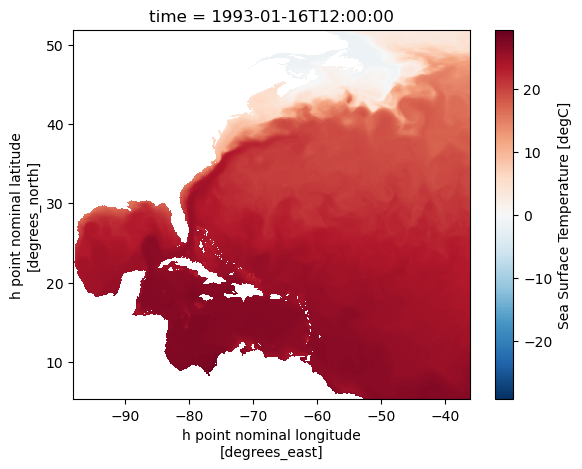

In [9]:
ds_subset['tos'].plot()

As mentioned earlier, raw grid data requires grid information provided by the model. To obtain this, we need the static file, which can be accessed using the same steps used to retrieve the variable file. The static file is typically located in the same folder, URL, or catalog as the raw data. Therefore, we can reuse the same `cefi_data_access` object created earlier for the variable field, and simply pass `variable="ocean_static"` to the `.get()` method.

In [10]:
static_urls = cefi_data_access.get(variable="ocean_static",print_list=True)

--------- All available files ------------
https://psl.noaa.gov/thredds/dodsC/Projects/CEFI/regional_mom6/cefi_portal/northwest_atlantic/full_domain/hindcast/monthly/raw/r20230520/ocean_static.nc


Here, we only want to retain the necessary information from the static file, which contains many additional grid variables. In this case, we need the tracer point longitude and latitude, located on the `xh` and `yh` grid coordinates, and stored under the variable names `geolon` and `geolat`.

In [11]:
ds_static = xr.open_dataset(static_urls[0], chunks={})
ds_static = ds_static[['geolon', 'geolat']].load()

In [12]:
ds_static

<xarray.Dataset> Size: 5MB
Dimensions:  (yh: 845, xh: 775)
Coordinates:
  * xh       (xh) float64 6kB -98.0 -97.92 -97.84 ... -36.24 -36.16 -36.08
  * yh       (yh) float64 7kB 5.273 5.352 5.432 5.511 ... 51.88 51.9 51.91 51.93
Data variables:
    geolon   (yh, xh) float32 3MB -98.0 -97.92 -97.84 ... -37.36 -37.27 -37.19
    geolat   (yh, xh) float32 3MB 5.273 5.273 5.273 5.273 ... 58.15 58.16 58.16
Attributes:
    _NCProperties:                   version=2,netcdf=4.9.0,hdf5=1.12.2
    NumFilesInSet:                   1
    title:                           NWA12_MOM6_v1.0
    grid_type:                       regular
    grid_tile:                       N/A
    history:                         Fri May 12 10:50:21 2023: ncks -4 -L 3 o...
    NCO:                             netCDF Operators version 5.0.1 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

As one can see from above, the coordinate is only `xh` and `yh` now. Let's merge the static dataset with the variable dataset.

In [13]:
ds_subset_static = xr.merge([ds_subset, ds_static])

To ensure that plotting and regridding work correctly, we need to set `geolon` and `geolat` as coordinates in the merged dataset, as they are initially listed as variables after the merge.


In [14]:
ds_subset_static = ds_subset_static.set_coords(['geolon','geolat'])

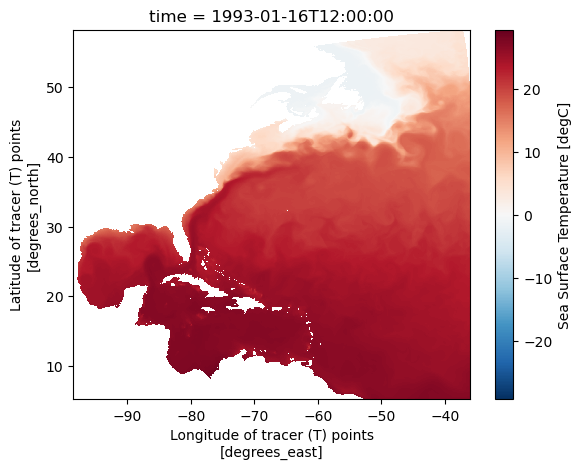

In [15]:
ds_subset_static.tos.plot(x='geolon', y='geolat')

## Get the data through AWS S3
Here we utilize the AWS S3 object storage as another data accessing method. We first define all the necessary information in a dictionary. These entries typically specify the details required to access a particular dataset. For this example, we will request the regridded dataset.


In [1]:
dict_data_info = {
    "region": "northwest_atlantic",
    "subdomain": "full_domain",
    "experiment_type": "hindcast",
    "output_frequency": "monthly",
    "grid_type": "regrid",
    "release": "r20230520",
    "data_source": "s3",
}

We use the `AccessFiles` class from the `mom6_read` module to specify the dataset information and data source. If the connection is successful, the class will return a standard message: `Success: URL ...`, indicating the URL to the dataset. This URL can also be used to browse the OPeNDAP catalog, which lists all available variables associated with the specified dataset.

In [2]:
from mom6.mom6_module.mom6_read import AccessFiles
cefi_data_access = AccessFiles(**dict_data_info)

ModuleNotFoundError: No module named 'mom6'

:::{admonition} Tip
:class: info
The `**dict_data_info` syntax unpacks the key-value pairs in the dictionary and passes them as keyword arguments required to create the `cefi_data_access` object
:::

Now let's focus on a single variable - `tos`(sea surface temperature) for downloading. The way to get the variable is through the `.get()` method and by providing the keyword argument `variable='tos'` we can narrow the list down to only `tos` related file on the server for this specific dataset. `print_list` argument help the user to see if there are multiple files that has the variable name `tos`. In this case, we only have one. 

In [ ]:
variable_urls = cefi_data_access.get(variable='ssh')

The `variable_urls` is a list object, in this case, only one element in the list.

In [ ]:
variable_urls

['s3://noaa-oar-cefi-regional-mom6-pds/northwest_atlantic/full_domain/hindcast/monthly/regrid/r20230520/ssh.nwa.full.hcast.monthly.regrid.r20230520.199301-201912.json']

We can now use the URL to access the file with the power of `Xarray`

In [1]:
import xarray as xr
import fsspec

fs = fsspec.filesystem(
    "reference", 
    fo='s3://noaa-oar-cefi-regional-mom6-pds/northwest_atlantic/full_domain/hindcast/monthly/regrid/r20230520/ssh.nwa.full.hcast.monthly.regrid.r20230520.199301-201912.json',
    remote_protocol="s3", 
    remote_options={"anon":True}
)
 
ds = xr.open_dataset(fs.get_mapper(""), engine='zarr',backend_kwargs={"consolidated": False})

In [7]:
ds_subset = ds.isel(time=0).load()

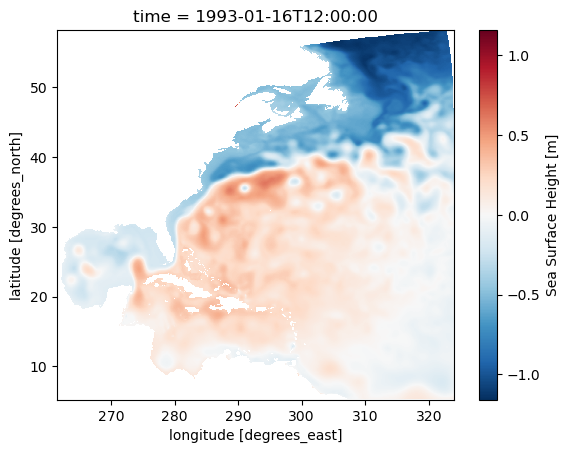

In [8]:
ds_subset.ssh.plot()

In [9]:
import s3fs, zarr
print('xarry version:', xr.__version__)
print('fsspec version:',fsspec.__version__)
print('zarr version:',zarr.__version__)
print('s3fs version:',s3fs.__version__)


xarry version: 2024.3.0
fsspec version: 2025.2.0
zarr version: 2.18.3
s3fs version: 2025.2.0
